In [457]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sns.set_style('whitegrid')

In [458]:
# Import maximum demands per locality

demand = pd.read_csv('demand.csv')

demand = (demand
          .set_index(pd.to_datetime(demand['Date']))
          .drop('Date', axis = 1)
          )

In [459]:
# Import day-ahead market prices
dam = pd.read_csv('dam.csv')

dam['Date'] = pd.to_datetime(dam['Date'])

dam = (dam
       .set_index(dam['Date']) # pd.to_datetime(dam['Date'])
       .drop('Date', axis = 1)
       )

dam = dam.reset_index().rename(columns = {'Date': 'date_old'})
dam['date_new'] = dam['date_old'] - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

dam = dam.drop('date_old', axis = 1).rename(columns = {'date_new': 'Date'}).set_index('Date')

dam.columns = ['nyca_dam', 'nyc_dam', 'li_dam', 'gj_dam']

In [460]:
# Import fuel prices
fuels = pd.read_csv('fuels.csv')
fuels = (fuels
         .set_index(pd.to_datetime(fuels['Date']))
         .drop('Date', axis = 1)
        )

In [461]:
# Import capacity prices
cap = pd.read_csv('cap.csv')
cap = (cap
       .set_index(pd.to_datetime(cap['Date'], format = '%b-%y'))
       .drop('Date', axis = 1)
       )
cap.columns = ['nyca_icap', 'gj_icap', 'nyc_icap', 'li_icap']

#cap.plot()

<Axes: xlabel='Date'>

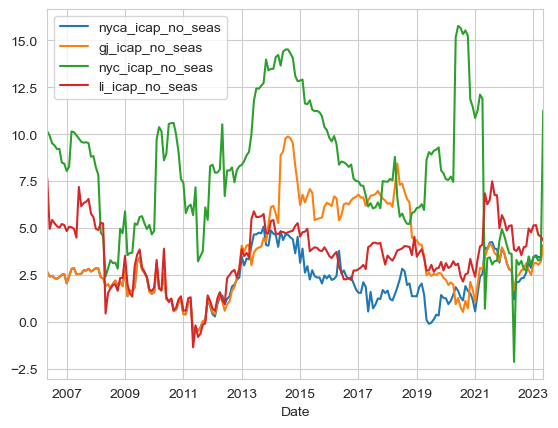

In [514]:
# Trend, seasonality decomposition

from statsmodels.tsa.seasonal import STL

trends = {}
no_seas = {}

for loc in cap.columns:
    trends[f"{loc}_trend"] = STL(cap[loc]).fit().trend
    trends[f"{loc}_season"] = STL(cap[loc]).fit().seasonal
    trends[f"{loc}_resid"] = STL(cap[loc]).fit().resid
    no_seas[f"{loc}_no_seas"] = trends[f"{loc}_trend"] + trends[f"{loc}_resid"]

trends = pd.DataFrame(trends)
no_seas = pd.DataFrame(no_seas)

no_seas.plot()

In [463]:
# Generation capacities

locs = ['GJ', 'LI', 'NYC']

gen = {}

for loc in locs:
    gen[loc] = pd.read_csv(f'../data\Generating_Capacity_{loc}_11-23.csv')
    gen[loc] = (gen[loc]
                .set_index(pd.to_datetime(gen[loc]['Date']))
                .drop('Date', axis = 1))
    
    oidx = gen[loc].index
    nidx = pd.date_range(oidx.min(), oidx.max(), freq = 'M')
    gen[loc] = gen[loc].reindex(oidx.union(nidx)).interpolate('index').reindex(nidx).shift(periods=-1, freq="m").shift(periods=1, freq="d")

gen['NYCA'] = pd.read_csv('../data\Generating_Capacity_NYCA_04-23.csv')
gen['NYCA'] = (gen['NYCA']
               .set_index(pd.to_datetime(gen['NYCA']['Date']))
               .drop('Date', axis = 1)
               )

oidx = gen['NYCA'].index
nidx = pd.date_range(oidx.min(), oidx.max(), freq = 'M')
gen['NYCA'] = gen['NYCA'].reindex(oidx.union(nidx)).interpolate('index').reindex(nidx).shift(periods=-1, freq="m").shift(periods=1, freq="d")

In [464]:
demand['NYC'].head()

Date
2006-02-01    6898.400000
2006-03-01    7591.366667
2006-04-01    8284.333333
2006-05-01    8977.300000
2006-06-01    9826.700000
Name: NYC, dtype: float64

In [465]:
gen['NYC'].head()

,Gas (NYC),Coal (NYC),Oil (NYC),Renewables (NYC),Others (NYC),Sum (NYC)
2011-01-01,8094.973973,0.0,1795.498630,0.0,0.0,9890.472603
2011-02-01,8067.603014,0.0,1790.550685,0.0,0.0,9858.153699
2011-03-01,8037.299452,0.0,1785.072603,0.0,0.0,9822.372055
2011-04-01,8007.973425,0.0,1779.771233,0.0,0.0,9787.744658
2011-05-01,7977.669863,0.0,1774.293151,0.0,0.0,9751.963014


In [468]:
# Create oversupply features
locs = ['GJ', 'LI', 'NYC', 'NYCA']
oversupply = {}
for loc in locs:
    oversupply[loc] = gen[loc].join(demand)
    oversupply[loc][f'Over_{loc}'] =  oversupply[loc][f'Sum ({loc})'] - oversupply[loc][loc]

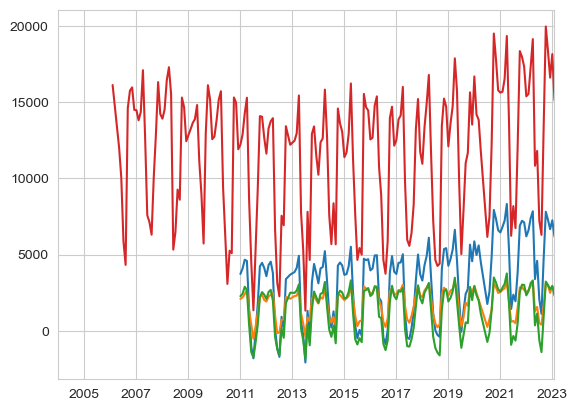

In [469]:
for loc in locs:
    oversupply[f'{loc}'][f'Over_{loc}'].plot()

In [519]:
oversupply['NYC']["Over_NYC_trend"] = STL(oversupply['NYC']['Over_NYC']).fit().trend
oversupply['NYC']["Over_NYC_season"] = STL(oversupply['NYC']['Over_NYC']).fit().seasonal
oversupply['NYC']["Over_NYC_resid"] = STL(oversupply['NYC']['Over_NYC']).fit().resid
oversupply['NYC']["Over_NYC_no_seas"] = STL(oversupply['NYC']['Over_NYC']).fit().trend + STL(oversupply['NYC']['Over_NYC']).fit().resid

<Axes: >

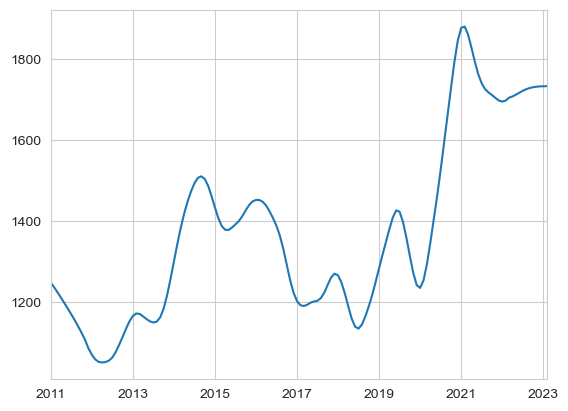

In [521]:
oversupply['NYC']['Over_NYC_trend'].plot()

In [523]:
no_seas_reg = oversupply['NYC'].join(no_seas).dropna(axis = 0)

In [527]:
no_seas_reg['ICAP-2'] = no_seas_reg['nyc_icap_no_seas'].shift(periods=24, freq="m").shift(periods=1, freq="d")

In [528]:
no_seas_reg = no_seas_reg.dropna(axis = 0)

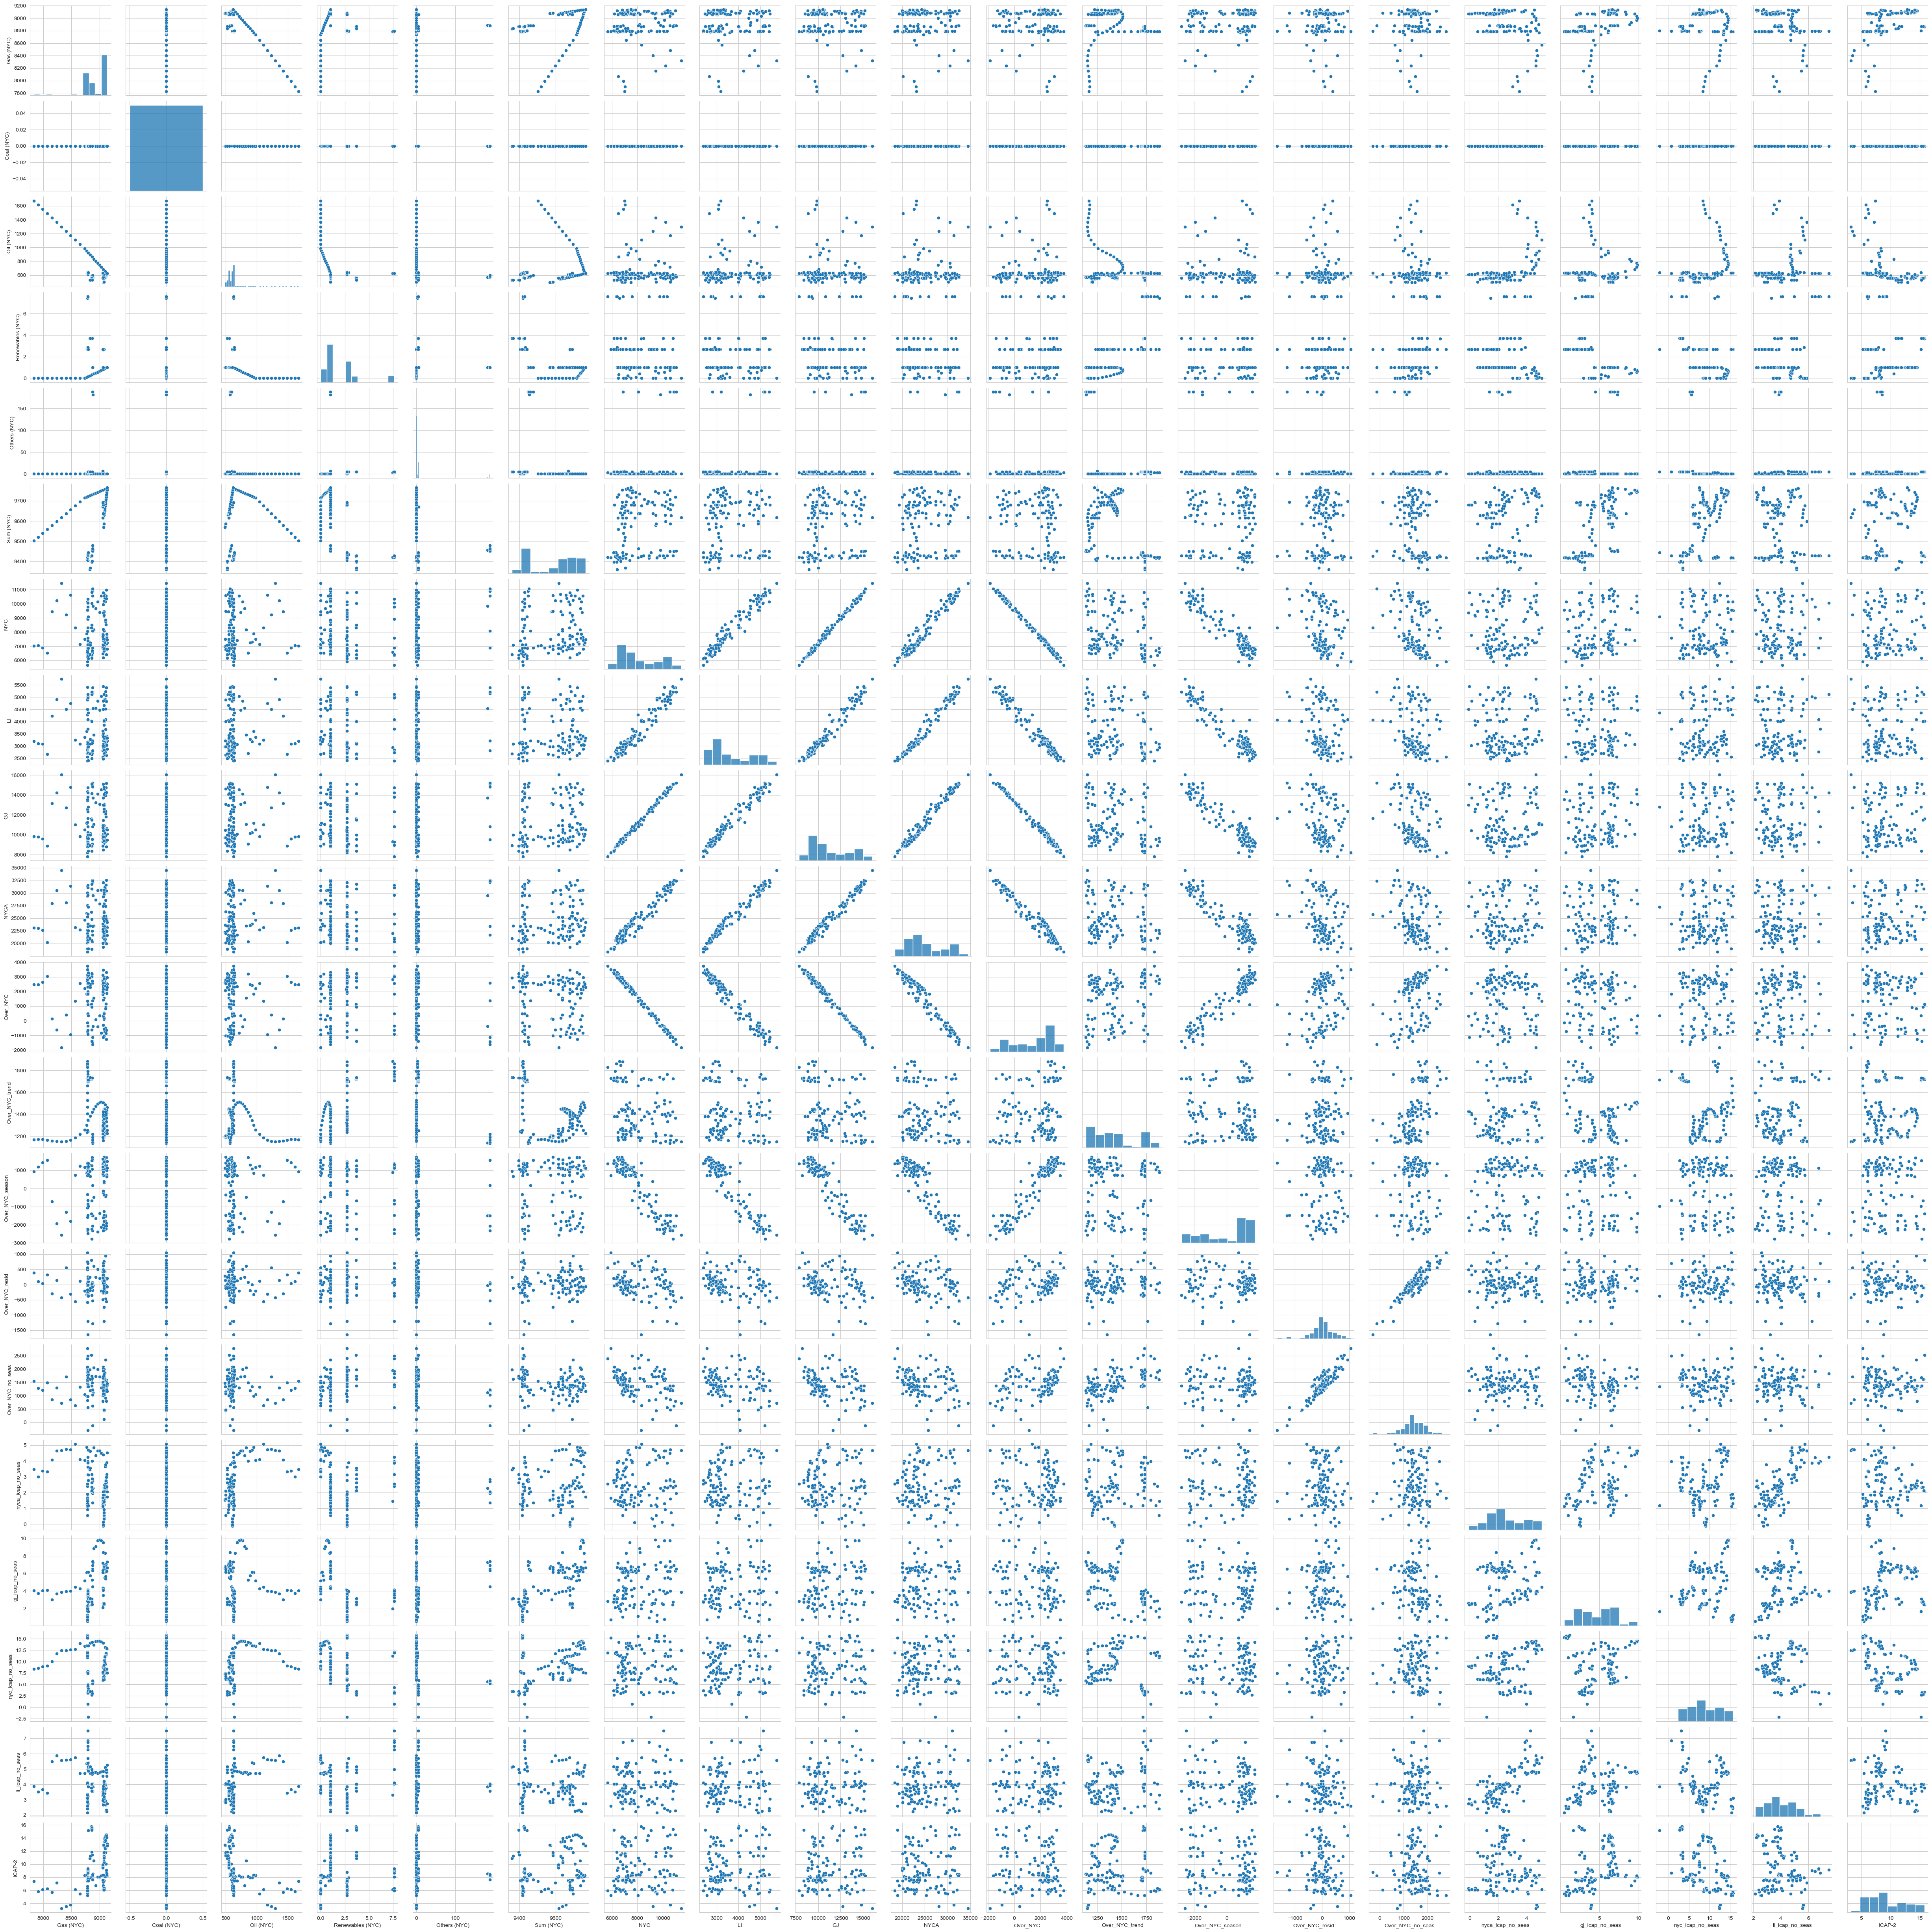

In [532]:
sns.pairplot(no_seas_reg)

In [529]:
no_seas_reg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2013-01-01 to 2023-02-01
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gas (NYC)          122 non-null    float64
 1   Coal (NYC)         122 non-null    float64
 2   Oil (NYC)          122 non-null    float64
 3   Renewables (NYC)   122 non-null    float64
 4   Others (NYC)       122 non-null    float64
 5   Sum (NYC)          122 non-null    float64
 6   NYC                122 non-null    float64
 7   LI                 122 non-null    float64
 8   GJ                 122 non-null    float64
 9   NYCA               122 non-null    float64
 10  Over_NYC           122 non-null    float64
 11  Over_NYC_trend     122 non-null    float64
 12  Over_NYC_season    122 non-null    float64
 13  Over_NYC_resid     122 non-null    float64
 14  Over_NYC_no_seas   122 non-null    float64
 15  nyca_icap_no_seas  122 non-null    float64
 16  gj_icap

In [530]:
x = no_seas_reg['ICAP-2']
y = no_seas_reg['Over_NYC_no_seas']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Over_NYC_no_seas   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                   0.03462
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.853
Time:                        18:24:28   Log-Likelihood:                -929.21
No. Observations:                 122   AIC:                             1862.
Df Residuals:                     120   BIC:                             1868.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1450.8149    144.072     10.070      0.0

In [470]:
# calculate sum of generating capacity excluding natural gas power plants
locs = ['GJ', 'LI', 'NYC', 'NYCA']
for loc in locs:
    gen[loc]['Sum_woGas (' + str(loc) + ')'] = gen[loc]['Sum (' + str(loc) + ')']-gen[loc]['Gas (' + str(loc) + ')']

In [471]:
nyc_icap_1 = pd.DataFrame()
nyc_icap_1['ICAP-1'] = cap['nyc_icap'].shift(periods=12, freq="m").shift(periods=1, freq="d")

nyc_dam_1 = pd.DataFrame()
nyc_dam_1['DAM-1'] = dam['nyc_dam'].shift(periods=12, freq="m").shift(periods=1, freq="d")

gj_icap_1 = pd.DataFrame()
gj_icap_1['ICAP-1'] = cap['gj_icap'].shift(periods=12, freq="m").shift(periods=1, freq="d")

gj_dam_1 = pd.DataFrame()
gj_dam_1['DAM-1'] = dam['gj_dam'].shift(periods=12, freq="m").shift(periods=1, freq="d")

li_icap_1 = pd.DataFrame()
li_icap_1['ICAP-1'] = cap['li_icap'].shift(periods=12, freq="m").shift(periods=1, freq="d")

li_dam_1 = pd.DataFrame()
li_dam_1['DAM-1'] = dam['li_dam'].shift(periods=12, freq="m").shift(periods=1, freq="d")

In [472]:
nyca_icap_2 = pd.DataFrame()
nyca_icap_2['ICAP-2'] = cap['nyca_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

nyca_dam_2 = pd.DataFrame()
nyca_dam_2['DAM-2'] = dam['nyca_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

nyc_icap_2 = pd.DataFrame()
nyc_icap_2['ICAP-2'] = cap['nyc_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

nyc_dam_2 = pd.DataFrame()
nyc_dam_2['DAM-2'] = dam['nyc_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

gj_icap_2 = pd.DataFrame()
gj_icap_2['ICAP-2'] = cap['gj_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

gj_dam_2 = pd.DataFrame()
gj_dam_2['DAM-2'] = dam['gj_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

li_icap_2 = pd.DataFrame()
li_icap_2['ICAP-2'] = cap['li_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

li_dam_2 = pd.DataFrame()
li_dam_2['DAM-2'] = dam['li_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

In [473]:
nyca_icap_3 = pd.DataFrame()
nyca_icap_3['ICAP-3'] = cap['nyca_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

nyca_dam_3 = pd.DataFrame()
nyca_dam_3['DAM-3'] = dam['nyca_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

nyc_icap_3 = pd.DataFrame()
nyc_icap_3['ICAP-3'] = cap['nyc_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

nyc_dam_3 = pd.DataFrame()
nyc_dam_3['DAM-3'] = dam['nyc_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

gj_icap_3 = pd.DataFrame()
gj_icap_3['ICAP-3'] = cap['gj_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

gj_dam_3 = pd.DataFrame()
gj_dam_3['DAM-3'] = dam['gj_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

li_icap_3 = pd.DataFrame()
li_icap_3['ICAP-3'] = cap['li_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

li_dam_3 = pd.DataFrame()
li_dam_3['DAM-3'] = dam['li_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

In [474]:
nyca_icap_4 = pd.DataFrame()
nyca_icap_4['ICAP-4'] = cap['nyca_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

nyca_dam_4 = pd.DataFrame()
nyca_dam_4['DAM-4'] = dam['nyca_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

nyc_icap_4 = pd.DataFrame()
nyc_icap_4['ICAP-4'] = cap['nyc_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

nyc_dam_4 = pd.DataFrame()
nyc_dam_4['DAM-4'] = dam['nyc_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

gj_icap_4 = pd.DataFrame()
gj_icap_4['ICAP-4'] = cap['gj_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

gj_dam_4 = pd.DataFrame()
gj_dam_4['DAM-4'] = dam['gj_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

li_icap_4 = pd.DataFrame()
li_icap_4['ICAP-4'] = cap['li_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

li_dam_4 = pd.DataFrame()
li_dam_4['DAM-4'] = dam['li_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

In [475]:
nyca_reg = (oversupply['NYCA']
            .join(cap)
            #.join(fuels)
            .join(dam)
            .join(nyca_icap_1)
            .join(nyca_icap_2)
            .join(nyca_icap_3)
            .join(nyca_icap_4)
            .join(nyca_dam_1)
            .join(nyca_dam_2)
            .join(nyca_dam_3)
            .join(nyca_dam_4)
            .dropna(axis = 0)
           )

In [476]:
nyc_reg = (oversupply['NYC']
            .join(cap)
            #.join(fuels)
            .join(dam)
            .join(nyc_icap_1)
            .join(nyc_icap_2)
            .join(nyc_icap_3)
            .join(nyc_icap_4)
            .join(nyc_dam_1)
            .join(nyc_dam_2)
            .join(nyc_dam_3)
            .join(nyc_dam_4)
            .dropna(axis = 0)
            )

In [477]:
gj_reg = (oversupply['GJ']
            .join(cap)
            #.join(fuels)
            .join(dam)
            .join(gj_icap_1)
            .join(gj_icap_2)
            .join(gj_icap_3)
            .join(gj_icap_4)
            .join(gj_dam_1)
            .join(gj_dam_2)
            .join(gj_dam_3)
            .join(gj_dam_4)
            .dropna(axis = 0)
            )

In [478]:
li_reg = (oversupply['LI']
            .join(cap)
            .join(fuels)
            .join(dam)
            .join(li_icap_1)
            .join(li_icap_2)
            .join(li_icap_3)
            .join(li_icap_4)
            .join(li_dam_1)
            .join(li_dam_2)
            .join(li_dam_3)
            .join(li_dam_4)
            .dropna(axis = 0)
            )

In [479]:
nyca_df = nyca_reg[['Over_NYCA', 
                    #'Coal (NYCA)',
                    #'Oil (NYCA)', 
                    #'Renewables (NYCA)', 
                    #'Others (NYCA)',
                    #'Sum (NYCA)',
                    #'Sum_woGas (NYCA)',
                    'nyca_icap',
                    #'natural gas', 
                    'nyca_dam', 
                    #'Cleared Above NYCA (%)', 
                    #'UCAP NYCA (MW)',
                    'ICAP-1', 
                    'ICAP-2', 
                    'ICAP-3', 
                    'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 
                    'DAM-3', 
                    'DAM-4'
                    ]]

#nyca_df['t'] = np.arange(1, len(nyca_df['Gas (NYCA)'])+1)

<Axes: >

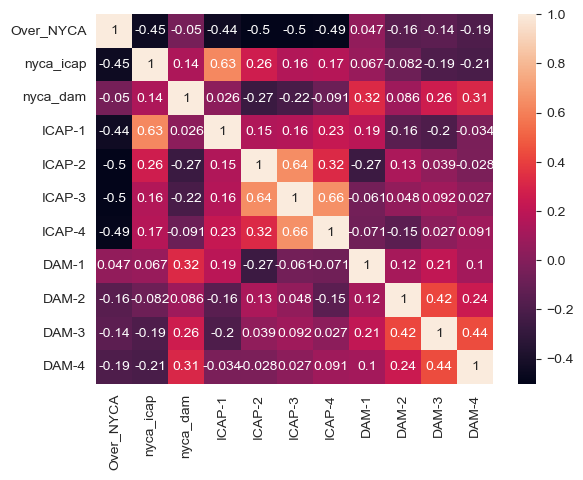

In [480]:
sns.heatmap(nyca_df.corr(), annot = True)

In [481]:
x = nyca_df.loc[:, nyca_df.columns != 'Over_NYCA']
y = nyca_df['Over_NYCA']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Over_NYCA   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     18.10
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           1.49e-20
Time:                        17:58:24   Log-Likelihood:                -1356.1
No. Observations:                 145   AIC:                             2734.
Df Residuals:                     134   BIC:                             2767.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.005e+04    957.590     20.936      0.0

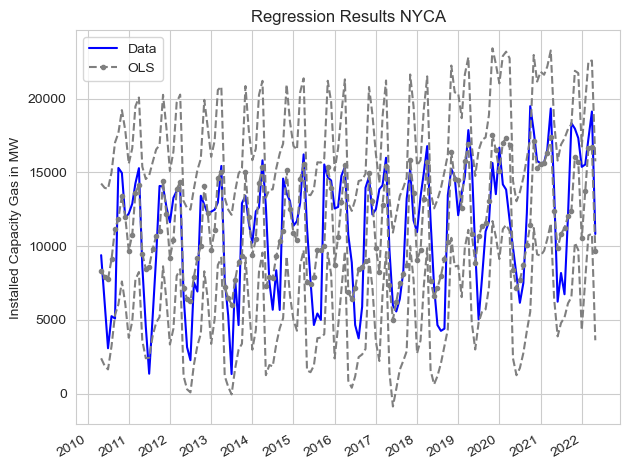

In [482]:
res = model
x = nyca_df.index
y_true = nyca_df['Over_NYCA']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b-', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
#ax.set_ylim(22000, 24500)
ax.set_title('Regression Results NYCA')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [483]:
nyc_reg.columns

Index(['Gas (NYC)', 'Coal (NYC)', 'Oil (NYC)', 'Renewables (NYC)',
       'Others (NYC)', 'Sum (NYC)', 'NYC', 'LI', 'GJ', 'NYCA', 'Over_NYC',
       'nyca_icap', 'gj_icap', 'nyc_icap', 'li_icap', 'nyca_dam', 'nyc_dam',
       'li_dam', 'gj_dam', 'ICAP-1', 'ICAP-2', 'ICAP-3', 'ICAP-4', 'DAM-1',
       'DAM-2', 'DAM-3', 'DAM-4'],
      dtype='object')

In [502]:
nyc_df = nyc_reg[['Over_NYC', 
                    #'Coal (NYC)',
                    # 'Oil (NYC)', 
                    #'Renewables (NYC)', 
                    #'Others (NYC)',
                    #'Sum (NYC)',
                    #'Sum_woGas (NYC)',
                    #'nyc_icap',
                    #'natural gas', 
                    #'nyc_dam', 
                    #'Cleared Above NYC (%)', 
                    #'UCAP NYC (MW)',
                    'ICAP-1', 
                    'ICAP-2', 'ICAP-3', 'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 'DAM-3', 'DAM-4'
                    ]]

<Axes: >

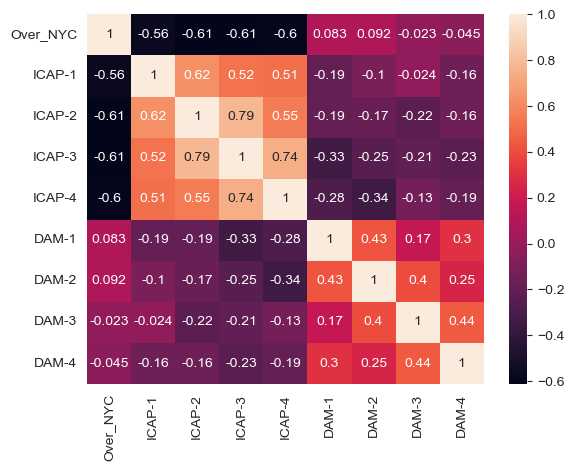

In [503]:
sns.heatmap(nyc_df.corr(), annot = True)

In [504]:
x = nyc_df.loc[:, nyc_df.columns != 'Over_NYC']
y = nyc_df['Over_NYC']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Over_NYC   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     20.82
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           2.15e-20
Time:                        17:59:58   Log-Likelihood:                -1219.7
No. Observations:                 146   AIC:                             2457.
Df Residuals:                     137   BIC:                             2484.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4734.8465    376.762     12.567      0.0

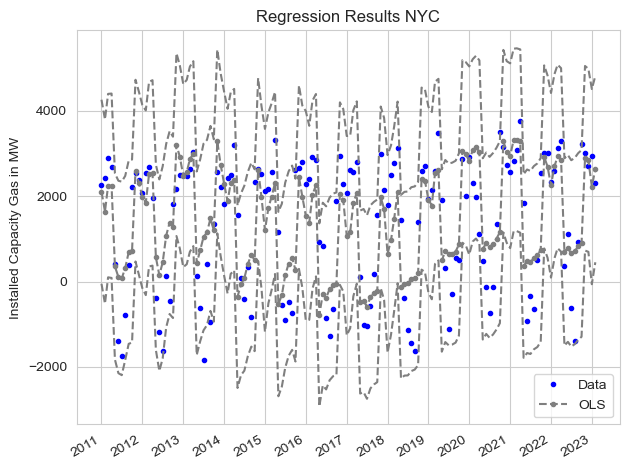

In [505]:
res = model
x = nyc_df.index
y_true = nyc_df['Over_NYC']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b-', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
#ax.set_ylim(8500, 9500)
ax.set_title('Regression Results NYC')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [506]:
gj_df = gj_reg[['Over_GJ', 
                    #'Coal (GJ)',
                    # 'Oil (GJ)', 
                    #'Renewables (GJ)', 
                    #'Others (GJ)',
                    #'Sum (GJ)',
                    #'Sum_woGas (GJ)',
                    #'gj_icap',
                    #'natural gas', 
                    #'gj_dam', 
                    #'Cleared Above GJ (%)', 
                    #'UCAP GJ (MW)',
                    'ICAP-1', 
                    'ICAP-2', 'ICAP-3', 'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 'DAM-3', 'DAM-4'
                    ]]

<Axes: >

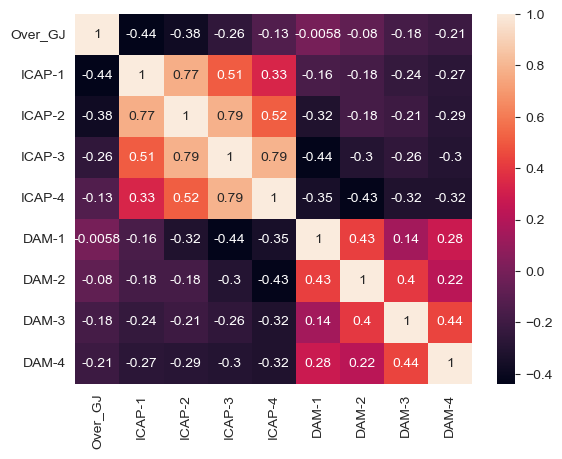

In [507]:
sns.heatmap(gj_df.corr(), annot = True)

In [508]:
x = gj_df.loc[:, gj_df.columns != 'Over_GJ']
y = gj_df['Over_GJ']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Over_GJ   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     9.613
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           1.63e-10
Time:                        18:01:21   Log-Likelihood:                -1312.4
No. Observations:                 146   AIC:                             2643.
Df Residuals:                     137   BIC:                             2670.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8032.7182    730.316     10.999      0.0

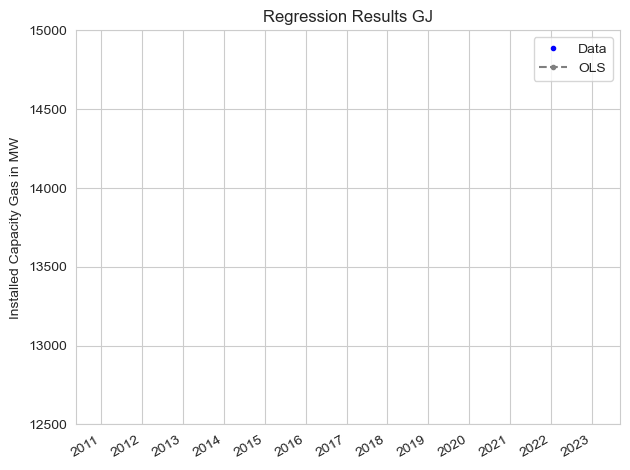

In [493]:
res = model
x = gj_df.index
y_true = gj_df['Over_GJ']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b-', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
#ax.set_ylim(12500, 15000)
ax.set_title('Regression Results GJ')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [494]:
li_df = li_reg[['Over_LI', 
                    #'Coal (LI)',
                    # 'Oil (LI)', 
                    #'Renewables (LI)', 
                    #'Others (LI)',
                    #'Sum (LI)',
                    #'Sum_woGas (LI)',
                    #'li_icap',
                    #'natural gas', 
                    #'li_dam', 
                    #'Cleared Above LI (%)', 
                    #'UCAP LI (MW)',
                    'ICAP-1', 
                    'ICAP-2', 'ICAP-3', 'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 'DAM-3', 'DAM-4'
                    ]]

<Axes: >

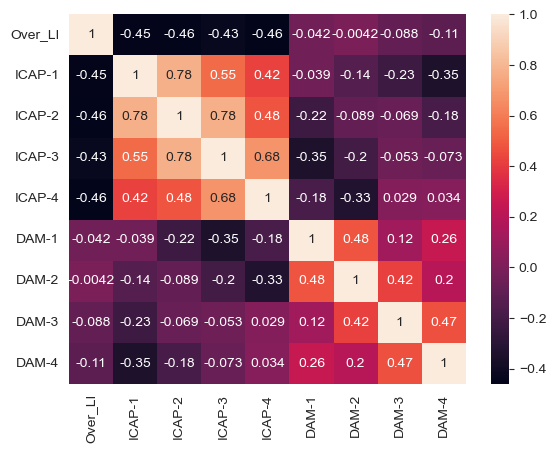

In [496]:
sns.heatmap(li_df.corr(), annot = True)

In [497]:
x = li_df.loc[:, li_df.columns != 'Over_LI']
y = li_df['Over_LI']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Over_LI   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     9.839
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           9.57e-11
Time:                        17:58:46   Log-Likelihood:                -1173.6
No. Observations:                 146   AIC:                             2365.
Df Residuals:                     137   BIC:                             2392.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3387.2270    245.959     13.772      0.0

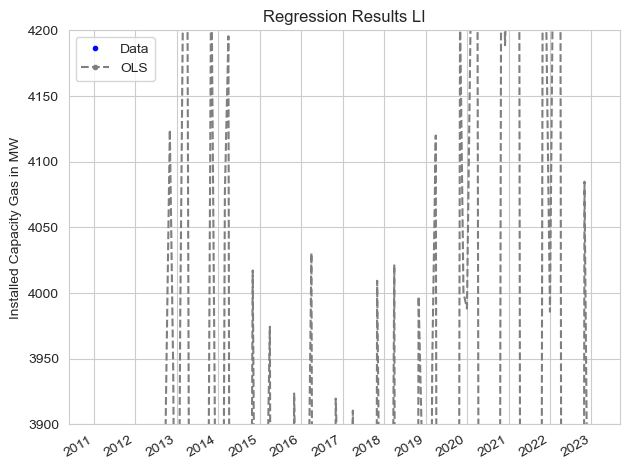

In [498]:
res = model
x = li_df.index
y_true = li_df['Over_LI']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b.', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
ax.set_ylim(3900, 4200)
ax.set_title('Regression Results LI')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [499]:
delta_li = (li_df - li_df.shift(1)) / li_df

In [500]:
delta_li = delta_li.dropna(axis = 0)

In [501]:
x = delta_li.loc[:, delta_li.columns != 'Over_LI']
y = delta_li['Over_LI']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Over_LI   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.6880
Date:                Mon, 19 Jun 2023   Prob (F-statistic):              0.702
Time:                        17:58:47   Log-Likelihood:                -204.09
No. Observations:                 145   AIC:                             426.2
Df Residuals:                     136   BIC:                             453.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1131      0.091     -1.249      0.2